# Object Matching

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)
import seaborn as sns
sns.set()

In [2]:
import monte_python

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["white", "red", "blue", "green", "purple", 'gray'])

In [3]:
def label_centroid(ax, object_props):
    """Place object label on object's centroid"""
    for region in object_props:
        x_cent,y_cent = region.centroid
        x_cent=int(x_cent)
        y_cent=int(y_cent)
        xx, yy = x[x_cent,y_cent], y[x_cent,y_cent]
        fontsize = 6.5 if region.label >= 10 else 8
        ax.text(xx,yy,
                    region.label,
                    fontsize=fontsize,
                    ha='center',
                    va='center',
                    color = 'k'
                    )

In [4]:
# Create fake storm data

fig=plt.figure(figsize=(10, 8), dpi= 300, facecolor='w', edgecolor='k')
g_len = 115
grid = np.zeros((2, g_len, g_len))
labels = np.zeros((2, g_len, g_len), dtype=int)
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
coords = np.dstack((x, y))
peak1_t0 = 1e4 * multivariate_normal(mean=[40, 45], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t0 = 1e4 * multivariate_normal(mean=[40, 58], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t0 = 1e4 * multivariate_normal(mean=[65, 90], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t0 = 1e4 * multivariate_normal(mean=[90,55], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t0 = 1e4 * multivariate_normal(mean=[40,20], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

peak1_t1 = 1e4 * multivariate_normal(mean=[50, 55], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t1 = 1e4 * multivariate_normal(mean=[45, 70], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t1 = 1e4 * multivariate_normal(mean=[75, 110], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t1 = 1e4 * multivariate_normal(mean=[95,65], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t1 = 1e4 * multivariate_normal(mean=[50, 30], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

grid[0] +=  peak1_t0+peak2_t0+peak3_t0+peak4_t0+peak5_t0
grid[1] +=  peak1_t1+peak2_t1+peak3_t1+peak4_t1+peak5_t1

<Figure size 3000x2400 with 0 Axes>

In [5]:
# For this example, we are using two iterations of the iterative watershed method. 
# However, if the expected objects existed across more spatial scales, we could introduce more
# iterations. 
param_set = [ {'min_thresh':10,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 200,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':25,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'area_threshold': 50,
                                 'dist_btw_objects': 10} 
            ]

params = {'params': param_set }

labels = []
for input_data in grid:
    input_data = np.where(input_data > 10, input_data, 0)
    storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = params,  
                       )
    labels.append((storm_labels, object_props))

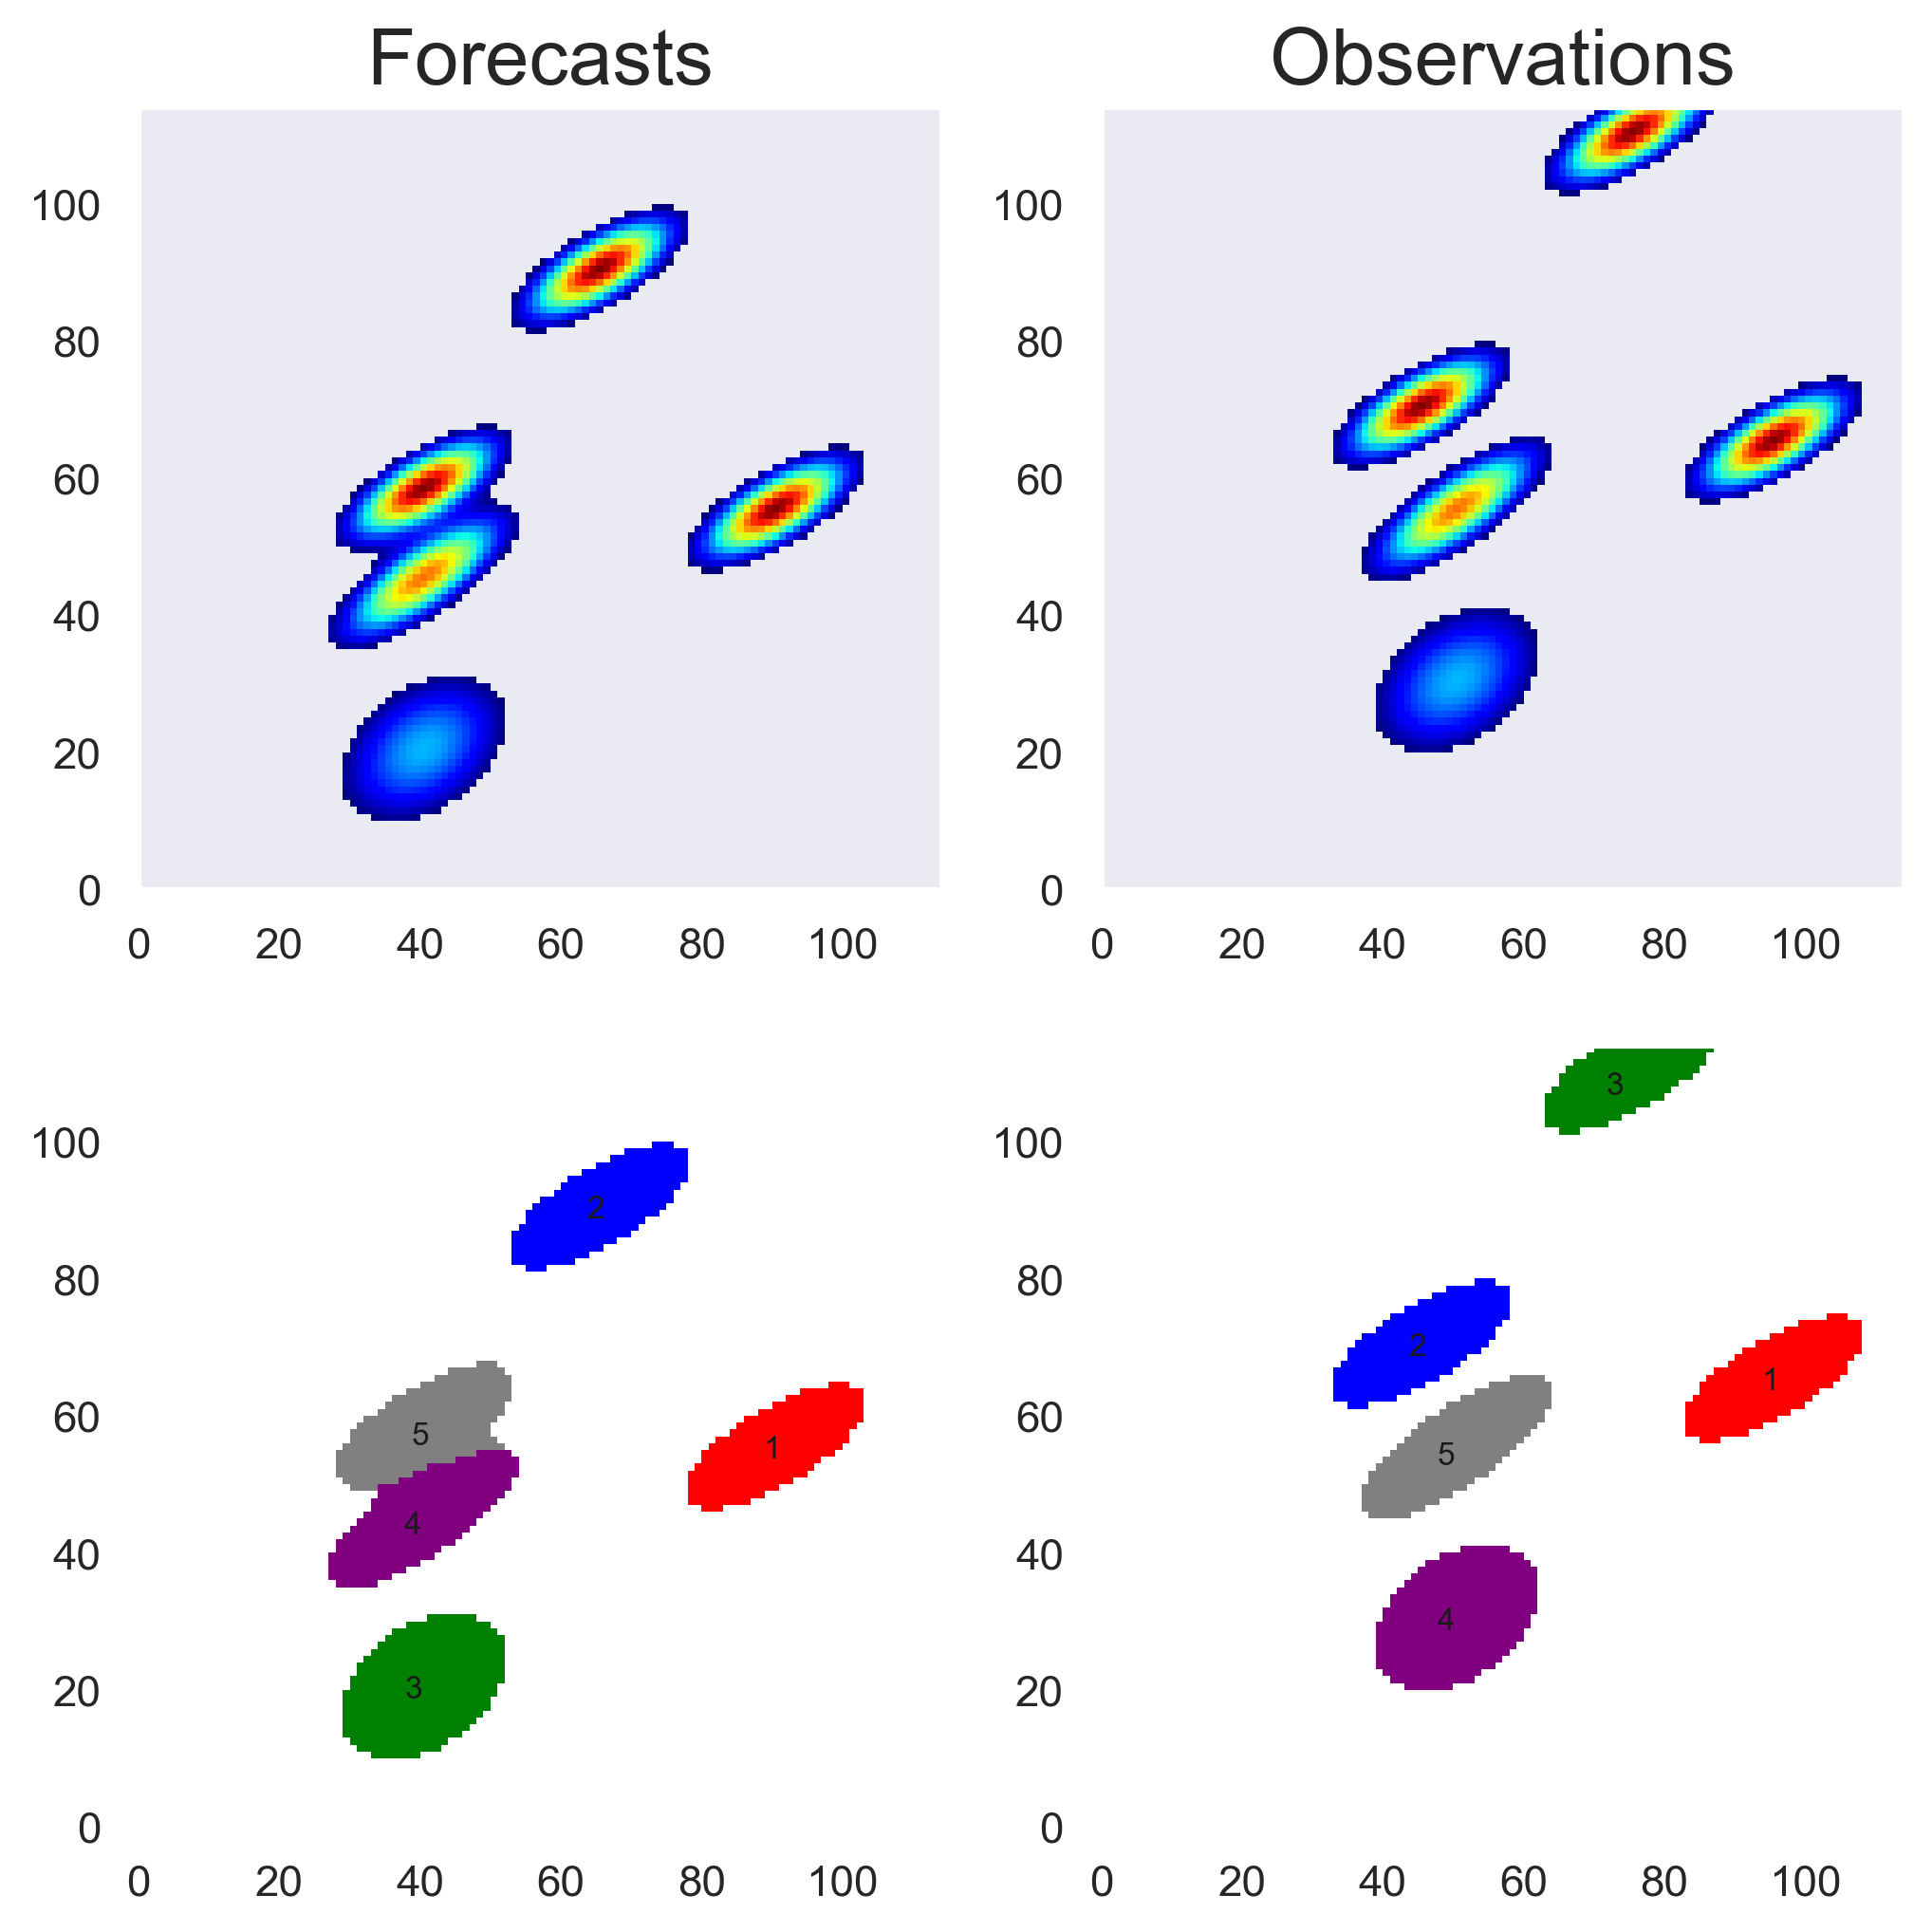

In [6]:
fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=300)
axs[0,0].set_title('Forecasts', fontsize=20)
axs[0,1].set_title('Observations', fontsize=20)
axs[0,0].pcolormesh(x, y, np.ma.array(grid[0], mask=grid[0] < 10), cmap='jet')
axs[0,1].pcolormesh(x, y, np.ma.array(grid[1], mask=grid[1] < 10), cmap='jet')
axs[1,0].pcolormesh(x, y, labels[0][0], cmap=cmap)
axs[1,1].pcolormesh(x, y, labels[1][0], cmap=cmap)
label_centroid(axs[1,0], labels[0][1])
label_centroid(axs[1,1], labels[1][1])

In [7]:
obj_match = monte_python.ObjectMatcher(cent_dist_max = 10, min_dist_max = 10, time_max=0, score_thresh=0.2, 
                           one_to_one = True)

# Match the objects 
matched_0, matched_1, _ = obj_match.match_objects(labels[0][0], labels[1][0])

In [8]:
def get_centroid_coords(label_props):
    '''Creates a dictionary with the object labels as keys 
    and the tuple of centroid coordinates as items'''
    centroids = {}
    for region in label_props:
        centroids[region.label] = region.centroid
    return centroids
        
label_cent_0 = get_centroid_coords(labels[0][1])    
label_cent_1 = get_centroid_coords(labels[1][1])

def matching_path(label_cent_0, label_cent_1, matched_0, matched_1):
    '''Associate matched objects and create their matching path'''
    x_set = []
    y_set = []
    for label_0, label_1 in zip(matched_0, matched_1):
        cent_0 = label_cent_0[label_0]
        cent_1 = label_cent_1[label_1]
        
        x1 = (cent_0[1], cent_1[1])
        y1 = (cent_0[0], cent_1[0])
        x_set.append(x1)
        y_set.append(y1)
    return x_set, y_set
    
x_set, y_set = matching_path(label_cent_0, label_cent_1, matched_0, matched_1)

Text(0.5, 1.0, 'Example of One-to-One Matching')

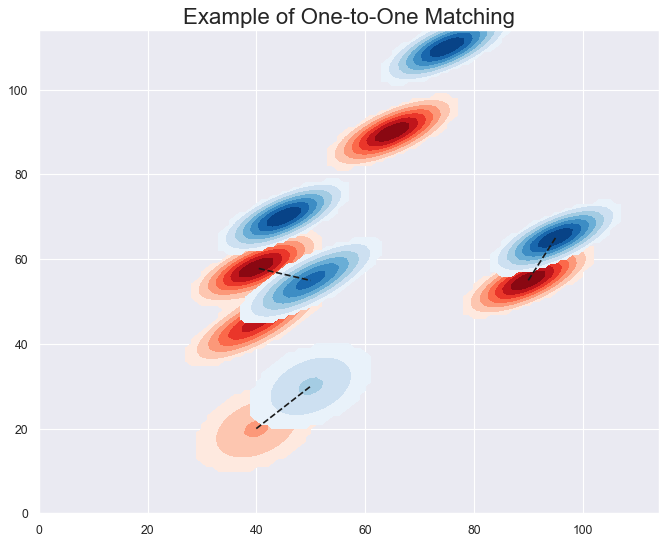

In [9]:
# Plot the matching path
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
plt.contourf(x, y, np.ma.array(grid[0], mask=labels[0][0] == 0), cmap='Reds')
plt.contourf(x, y, np.ma.array(grid[1], mask=labels[1][0] == 0), cmap='Blues')
for x1, y1 in zip(x_set, y_set):
    plt.plot(x1,y1, linestyle='dashed', color='k')
    
plt.title('Example of One-to-One Matching', fontsize=20)

In [10]:
obj_match = monte_python.ObjectMatcher(cent_dist_max = 10, min_dist_max = 10, time_max=0, score_thresh=0.2, 
                           one_to_one = False)

# Match the objects 
matched_0, matched_1, _ = obj_match.match_objects(labels[0][0], labels[1][0])

Text(0.5, 1.0, 'Example of Non-One-to-One Matching')

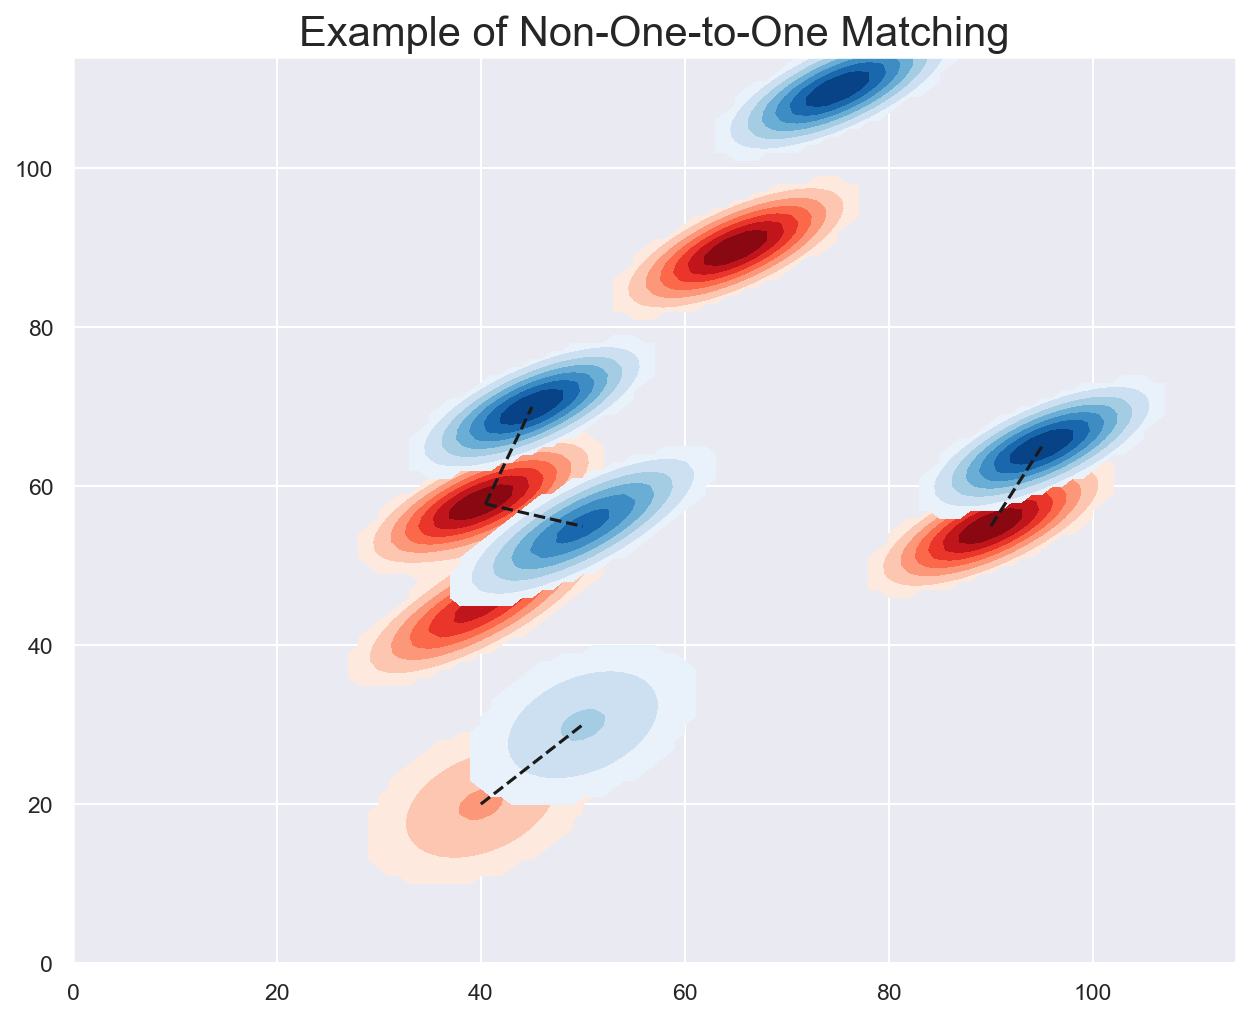

In [11]:
x_set, y_set = matching_path(label_cent_0, label_cent_1, matched_0, matched_1)
# Plot the matching path
fig=plt.figure(figsize=(10, 8), dpi= 150, facecolor='w', edgecolor='k')
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
plt.contourf(x, y, np.ma.array(grid[0], mask=labels[0][0] == 0), cmap='Reds')
plt.contourf(x, y, np.ma.array(grid[1], mask=labels[1][0] == 0), cmap='Blues')
for x1, y1 in zip(x_set, y_set):
    plt.plot(x1,y1, linestyle='dashed', color='k')

plt.title('Example of Non-One-to-One Matching', fontsize=20)